# Clustering


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
from pyclustertend import hopkins, vat
from sklearn.metrics import silhouette_score

#### _1.1 Haga el preprocesamiento del dataset, explique qué variables no aportan información a la generación de grupos y por qué. Describa con qué variables calculará los grupos_


<small>

**Variables que no aportan información para clústering:**

Es importante resaltar que clustering se maneja por medio de valores numéricos. Por lo tanto, los valores que no aportan información para clústering son:

1. **id:** Es solo el identificador único, no tiene relevancia para la agrupación.
2. **homepage:** Debido a que es una URL, no aporta valor numérico o categórico relevante.
3. **originalTile y title:** Es el nombre de las películas, no aportan información cuantificable.
4. **originalLanguage:** Es una variable categórica con demasiadas clases, no es relevante para el clústering.
5. **releaseDate:** Es una fecha que no aporta información numérica útil directamente.
6. **director, actor, actorsCharacter:** Son nombres de personas, no datos útiles para análisis cuantitativo.
7. **video:** Contiene valores _True/False_, lo cual no es tan útil para el clustering en este caso.
8. **productionCompany, productionCompanyCountry, productionCountry, genres:** Su formato textual dificulta el uso de clustering.

</small>


<small>

**Variables Seleccionadas para Calcular los Grupos**

Cabe resaltar que todas las variables seleccionadas para calcular grupos, son de tipo cuantitativo.

1. budget
2. revenue
3. popularity
4. voteAvg
5. voteCount
6. runtime
7. genresAmount
8. productionCoAmount
9. productionCountriesAmount
10. actosPopularity
11. actorsAmount
12. castWomenAmount
13. castMenAmount
    </small>


### Análisis de agrupamientos de datos realizados


<small>

#### **Variables de rendimiento financiero**

1. Budget
2. Revenue
3. Popularity
4. VoteAvg
5. VoteCount

**Razón de agrupamiento:** Estas variables están relacionadas con el desempeño económico y la recepción del público. Las películas con un presupuesto elevado podría esperar una mayor recaudación y la popularidad o promedio de votos puede ayudar a identificar patrones de éxito o fracaso. Al agruparlas, se puede detectar si existe un segmento de películas con alta inversión y alta recaudación vs otro con baja inversión y bajo rendimiento.

#### **Variables de producción, diversidad y tiempo**

1. GenresAmount
2. ProductionCoAmount
3. ProductionCountriesAmount
4. Runtime

**Razón de agrupamiento:** Estas variables reflejan la diversidad, complejidad del proceso productivo y el tiempo total del resultado. Por ejemplo, se pueden tener películas con múltiples géneros que involucran varias compañías y países que pueden tener estrategias de marketing o distribución muy distintas a aquellas producidas de forma más limitada. Por lo que puede influir en la percepción del público, rendimiento económico, etc.

#### **Variables relacionadas con el elenco**

1. actosPopularity_avg
2. actorsAmount
3. castWomenAmount y castMenAmount

**Razón de agrupamiento:** El potencial comercial del elenco es un factor importante en la industria del cine. Un reparto con actores reconocidos o con alta popularidad puede atraer a una audiencia mayor, lo cual podría relacionarse con mejores resultados en taquilla y recepción crítica. Además, el balance entre cast femenino y masculino puede ser interesante para identificar tendencias en ciertos géneros o estilos de producción.

</small>


### Limpieza de filas con datos no númericos en filas numéricas y filas con columnas sin valor en el dataset


In [ ]:
file_path = "movies.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Seleccionar las variables cuantitativas para clustering
columnas = ['budget', 'revenue', 'runtime', 'actorsPopularity_avg', 'popularity',
            'voteAvg', 'voteCount', 'genresAmount', 'productionCoAmount', 
            'productionCountriesAmount', 'actorsAmount', 'castWomenAmount', 'castMenAmount']

# Promediar la popularidad de los actores debido a divisione con '|'
def promedio_actors_popularity(cadena):
    try:
        valores = [pd.to_numeric(x, errors='coerce') for x in cadena.split('|')]
        return np.nanmean(valores)
    except:
        return np.nan

df['actorsPopularity_avg'] = df['actorsPopularity'].apply(promedio_actors_popularity)

# Convertir las columnas a numérico
for col in columnas:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Definir los grupos de variables según las dimensiones conceptuales

# Grupo 1: Variables de rendimiento financiero
group1_features = ["budget", "revenue", "popularity", "voteAvg", "voteCount"]

# Grupo 2: Variables de producción, diversidad y tiempo
group2_features = ["genresAmount", "productionCoAmount", "productionCountriesAmount", "runtime"]

# Grupo 3: Variables relacionadas con el elenco
group3_features = ["actorsPopularity_avg", "actorsAmount", "castWomenAmount", "castMenAmount"]

# Crear los DataFrames para cada grupo
df_group1 = df[group1_features].copy()
df_group1.fillna(df_group1.median(numeric_only=True), inplace=True)

df_group2 = df[group2_features].copy()
df_group2.fillna(df_group2.median(numeric_only=True), inplace=True)

df_group3 = df[group3_features].copy()
df_group3.fillna(df_group3.median(numeric_only=True), inplace=True)


C:\Users\ncast\AppData\Local\Temp\ipykernel_3144\3351978975.py:13: RuntimeWarning: Mean of empty slice
  return np.nanmean(valores)


#### _1.2 Analice la tendencia al agrupamiento usando el estadístico de Hopkings y la VAT (Visual Assessment of cluster Tendency). Esta última hágala si es posible, teniendo en cuenta las dimensiones del conjunto de datos. Discuta sus resultados e impresiones._


In [13]:
# Asegurarse de que todas las columnas sean numéricas y manejar valores nulos (usando la mediana)
for group in [df_group1, df_group2, df_group3]:
    for col in group.columns:
        group[col] = pd.to_numeric(group[col], errors='coerce')
    group.fillna(group.median(numeric_only=True), inplace=True)

# Normalizar cada grupo de variables
group1_scaled = scale(df_group1)
group2_scaled = scale(df_group2)
group3_scaled = scale(df_group3)

# Calcular el estadístico de Hopkins para cada grupo
hopkins_group1 = hopkins(group1_scaled, group1_scaled.shape[0])
hopkins_group2 = hopkins(group2_scaled, group2_scaled.shape[0])
hopkins_group3 = hopkins(group3_scaled, group3_scaled.shape[0])

print("\nEstadístico de Hopkins para cada grupo:")
print("Hopkins statistic for Group 1 (Rendimiento financiero): {:.4f}".format(hopkins_group1))
print("Hopkins statistic for Group 2 (Producción, diversidad y tiempo): {:.4f}".format(hopkins_group2))
print("Hopkins statistic for Group 3 (Elenco): {:.4f}".format(hopkins_group3))

print("\nEstadístico de VAT para cada grupo:")
# 4. Visual Assessment of Cluster Tendency (VAT)
def plot_vat(data, group_name):
    if data.shape[0] > 5000:
        # Si el número de registros excede 5000, no se calcula la VAT
        print(f"VAT para {group_name} omitida: el conjunto de datos tiene {data.shape[0]} registros, lo que excede el límite para una visualización efectiva.")
    else:
        print(f"VAT para {group_name}")
        vat(data)

# Visualizar (o discutir la imposibilidad de visualizar) la VAT para cada grupo
plot_vat(group1_scaled, "Grupo 1 (Rendimiento financiero)")
plot_vat(group2_scaled, "Grupo 2 (Producción, diversidad y tiempo)")
plot_vat(group3_scaled, "Grupo 3 (Elenco)")


Estadístico de Hopkins para cada grupo:
Hopkins statistic for Group 1 (Rendimiento financiero): 0.0149
Hopkins statistic for Group 2 (Producción, diversidad y tiempo): 0.0032
Hopkins statistic for Group 3 (Elenco): 0.0019

Estadístico de VAT para cada grupo:
VAT para Grupo 1 (Rendimiento financiero) omitida: el conjunto de datos tiene 10000 registros, lo que excede el límite para una visualización efectiva.
VAT para Grupo 2 (Producción, diversidad y tiempo) omitida: el conjunto de datos tiene 10000 registros, lo que excede el límite para una visualización efectiva.
VAT para Grupo 3 (Elenco) omitida: el conjunto de datos tiene 10000 registros, lo que excede el límite para una visualización efectiva.


<small>

### **Análisis de Hopkins**

Los resultados obtenidos para el estadístico de Hopkins fueron los siguientes:

1. Grupo 1 (Rendimiento financiero): 0.0149
2. Grupo 2 (Producción, diversidad y tiempo): 0.0033
3. Grupo 3 (Elenco): 0.0019

Estos valores son extremadamente bajos y sugieren una muy alta propensión al agrupamiento en cada uno de los grupos. En el contexto de la minería de datos, un valor tan cercano a cero indica que los datos no se distribuyen de forma aleatoria, sino que presentan patrones intrínsecos que favorecen la formación de clusters. Esto implica que, al aplicar técnicas de clustering, es muy probable que se identifiquen grupos significativos en cada una de las dimensiones analizadas (financiera, de producción/diversidad y de elenco).

### **Análisis de VAT**

La aplicación de la técnica de Visual Assessment of Cluster Tendency (VAT) fue omitida para cada grupo, ya que el conjunto de datos cuenta con 10,000 registros, lo que excede el límite para una visualización efectiva.
La técnica VAT es una herramienta muy útil para identificar visualmente la existencia de grupos naturales, ya que reordena la matriz de disimilitud de manera que se pueden observar bloques oscuros representativos de clusters. Sin embargo, en conjuntos de datos muy grandes, la complejidad y el elevado número de elementos dificultan la interpretación de la matriz de disimilitud, haciendo que la visualización no aporte información clara ni concluyente.
</small>


#### _1.3 Determine cuál es el número de grupos a formar más adecuado para los datos que está trabajando. Haga una gráfica de codo y explique la razón de la elección de la cantidad de clústeres con la que trabajará._


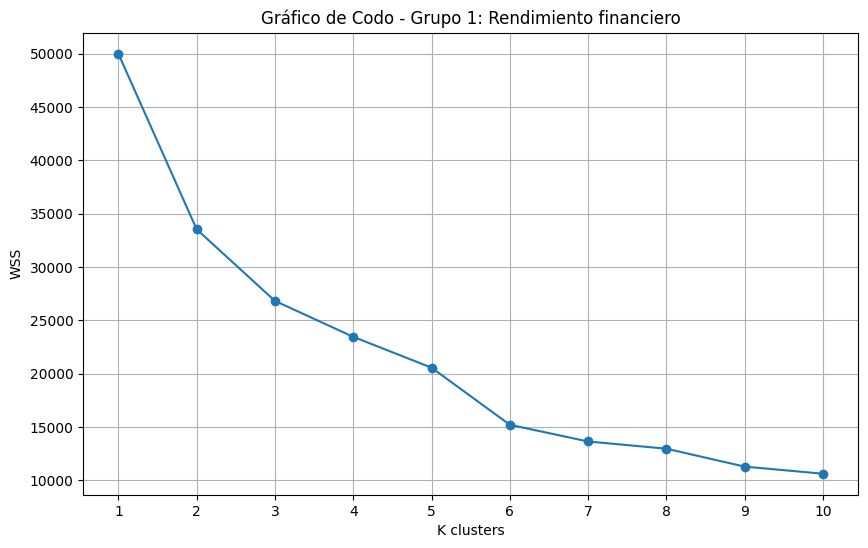

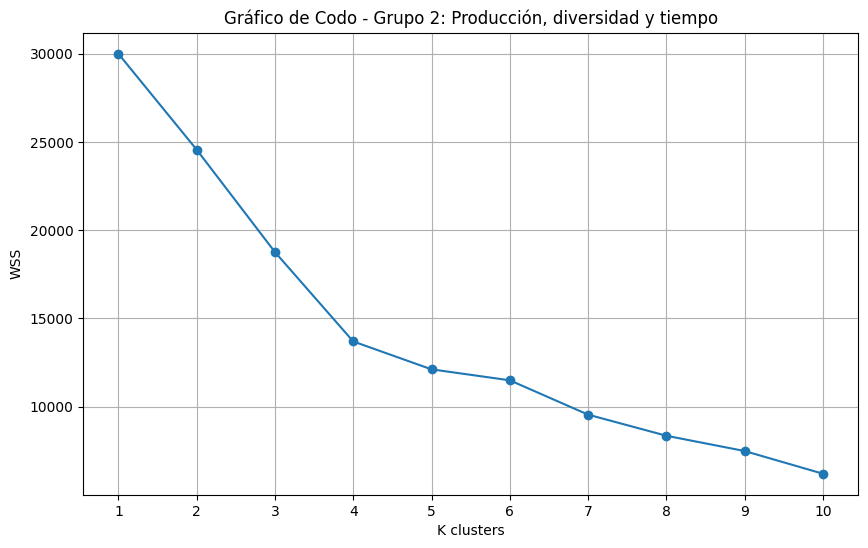

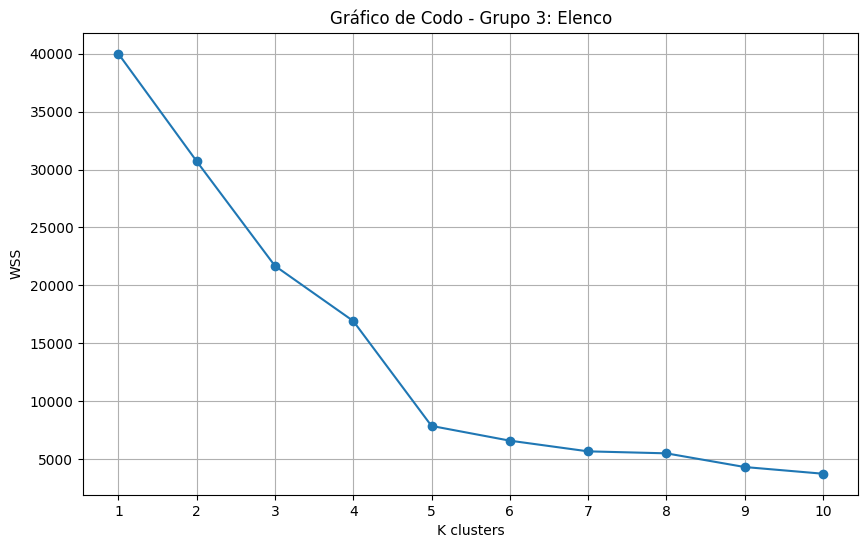

In [20]:
def elbow_plot_for_group(features, group_name):
    # Extraer el subconjunto de datos para el grupo
    df_group = df[features].copy()
    # Convertir a numérico y llenar valores faltantes con la mediana
    for col in features:
        df_group[col] = pd.to_numeric(df_group[col], errors='coerce')
    df_group.fillna(df_group.median(numeric_only=True), inplace=True)
    
    # Normalizar los datos
    X_scale = scale(df_group)
    
    # Aplicar el método del codo
    numeroClusters = range(1, 11)
    wcss = []
    for i in numeroClusters:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X_scale)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(numeroClusters, wcss, marker='o')
    plt.xticks(numeroClusters)
    plt.xlabel("K clusters")
    plt.ylabel("WSS")
    plt.title(f"Gráfico de Codo - {group_name}")
    plt.grid(True)
    plt.show()

# Generar la gráfica del codo para cada grupo:
elbow_plot_for_group(group1_features, "Grupo 1: Rendimiento financiero")
elbow_plot_for_group(group2_features, "Grupo 2: Producción, diversidad y tiempo")
elbow_plot_for_group(group3_features, "Grupo 3: Elenco")

<small>

### Análisis de gráfica de codo

**Grupo 1: Rendimiento financiero**

Observaciones de la curva:

1. Se inicia con un valor de WSS cercado a 50,000 para k=1
2. Hay caídas fuertes de k=1 a k=2 y de k=2 a k=3
3. A partir de k=4 o k=5, la pendiente se reduce de forma gradual.

**Selección de cantidad de clústers:** Considerando lo anterior, un punto razonable para la elección de la cantidad de clústeres con las que se trabajará es k=5, donde la ganancia entre un valor y el siguiente comienza a ser más moderada.

**Grupo 2: Producción, diversidad y tiempo**

Observaciones de la curva:

1. Aunque no se nota un "codo" tan marcado como el grupo anterior, se aprecia una reducción significativa hasta aproximadamente k=7 o k=8 donde la curva se ve más progresiva.

**Selección de cantidad de clústers:** Considerando el análisis, un valor de k=8 podría considerarse un buen equilibrio, ya que la disminución de WSS es más notable apartir de este punto.

**Grupo 3: Elenco**

Observaciones de la curva:

1. La WSS parte de un valor cercano a 40,000 para k=1 y disminuye abruptamente hasta al rededor de k=5000 para k=5.
2. A partir de k=6 o k=7, la curva sigue bajando, pero de manera menos pronunciada.

**Selección de cantidad de clústers:** Dada la fuerte caída hasta k=5, este valor podría segmentar de forma razonable.

</small>


#### _1.4 Utilice los algoritmos k-medias y clustering jerárquico para agrupar. Compare los resultados generados por cada uno._


#### Cálculo k-medias


K-Means Grupo 1 (Rendimiento financiero):
 KMeans(n_clusters=4)
Centroides Grupo 1:
 [[-0.32960781 -0.25826882 -0.03969036  0.65631934 -0.21433718]
 [ 1.51479443  1.11284631  0.10321319  0.27540812  1.28112954]
 [-0.2388823  -0.27494533 -0.07883049 -0.94633862 -0.34624464]
 [ 3.79062601  4.98620416  1.80630294  0.8067486   4.37568697]]


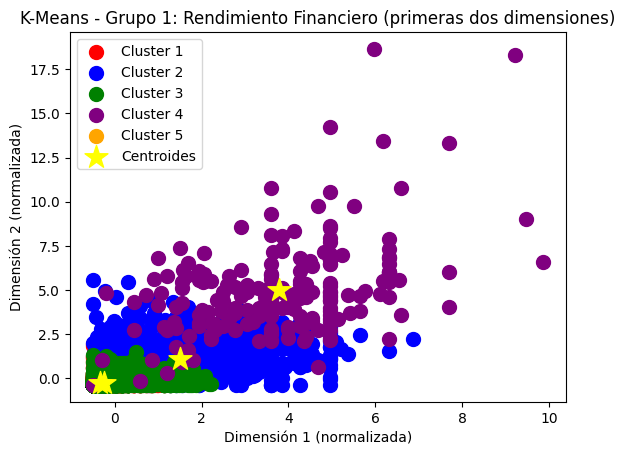


K-Means Grupo 2 (Producción, diversidad y tiempo):
 KMeans(n_clusters=5)
Centroides Grupo 2:
 [[ 0.92247213 -0.24289444 -0.13645072 -0.36195709]
 [ 0.03824583  2.04963939  0.18406558  0.2254344 ]
 [ 0.07523435 -0.02546557 -0.10491483  1.10383403]
 [-0.89560458 -0.32649998 -0.1273427  -0.32876808]
 [-0.39219095 -0.75598322  5.47636873 -0.39230522]]


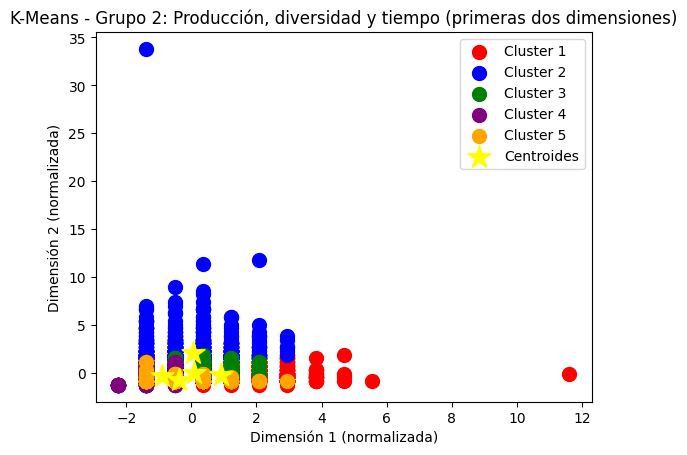

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [3]:
X1 = scale(df_group1)  # Escalamos las variables

# K-Means 
km_g1 = KMeans(n_clusters=4).fit(X1)
print("K-Means Grupo 1 (Rendimiento financiero):\n", km_g1)

# Centroides de los clusters
centroides_g1 = km_g1.cluster_centers_
print("Centroides Grupo 1:\n", centroides_g1)

# Predicción de clusters
especies_g1 = km_g1.predict(X1)

# Gráfica 
plt.scatter(X1[especies_g1 == 0, 0], X1[especies_g1 == 0, 1], s=100, c='red', label="Cluster 1")
plt.scatter(X1[especies_g1 == 1, 0], X1[especies_g1 == 1, 1], s=100, c='blue', label="Cluster 2")
plt.scatter(X1[especies_g1 == 2, 0], X1[especies_g1 == 2, 1], s=100, c='green', label="Cluster 3")
plt.scatter(X1[especies_g1 == 3, 0], X1[especies_g1 == 3, 1], s=100, c='purple', label="Cluster 4")
plt.scatter(X1[especies_g1 == 4, 0], X1[especies_g1 == 4, 1], s=100, c='orange', label="Cluster 5")

# Centroides (también en 2D)
plt.scatter(centroides_g1[:,0], centroides_g1[:,1], s=300, c="yellow", marker="*", label="Centroides")
plt.title("K-Means - Grupo 1: Rendimiento Financiero (primeras dos dimensiones)")
plt.xlabel("Dimensión 1 (normalizada)")
plt.ylabel("Dimensión 2 (normalizada)")
plt.legend()
plt.show()


# -------------- GRUPO 2: Producción, diversidad y tiempo --------------
X2 = scale(df_group2)

km_g2 = KMeans(n_clusters=5).fit(X2)
print("\nK-Means Grupo 2 (Producción, diversidad y tiempo):\n", km_g2)

centroides_g2 = km_g2.cluster_centers_
print("Centroides Grupo 2:\n", centroides_g2)

especies_g2 = km_g2.predict(X2)

plt.scatter(X2[especies_g2 == 0, 0], X2[especies_g2 == 0, 1], s=100, c='red', label="Cluster 1")
plt.scatter(X2[especies_g2 == 1, 0], X2[especies_g2 == 1, 1], s=100, c='blue', label="Cluster 2")
plt.scatter(X2[especies_g2 == 2, 0], X2[especies_g2 == 2, 1], s=100, c='green', label="Cluster 3")
plt.scatter(X2[especies_g2 == 3, 0], X2[especies_g2 == 3, 1], s=100, c='purple', label="Cluster 4")
plt.scatter(X2[especies_g2 == 4, 0], X2[especies_g2 == 4, 1], s=100, c='orange', label="Cluster 5")

plt.scatter(centroides_g2[:,0], centroides_g2[:,1], s=300, c="yellow", marker="*", label="Centroides")
plt.title("K-Means - Grupo 2: Producción, diversidad y tiempo (primeras dos dimensiones)")
plt.xlabel("Dimensión 1 (normalizada)")
plt.ylabel("Dimensión 2 (normalizada)")
plt.legend()
plt.show()


# -------------- GRUPO 3: Elenco --------------
X3 = scale(df_group3)

km_g3 = KMeans(n_clusters=5).fit(X3)
print("\nK-Means Grupo 3 (Elenco):\n", km_g3)

centroides_g3 = km_g3.cluster_centers_
print("Centroides Grupo 3:\n", centroides_g3)

especies_g3 = km_g3.predict(X3)

plt.scatter(X3[especies_g3 == 0, 0], X3[especies_g3 == 0, 1], s=100, c='red', label="Cluster 1")
plt.scatter(X3[especies_g3 == 1, 0], X3[especies_g3 == 1, 1], s=100, c='blue', label="Cluster 2")
plt.scatter(X3[especies_g3 == 2, 0], X3[especies_g3 == 2, 1], s=100, c='green', label="Cluster 3")
plt.scatter(X3[especies_g3 == 3, 0], X3[especies_g3 == 3, 1], s=100, c='purple', label="Cluster 4")
plt.scatter(X2[especies_g2 == 4, 0], X2[especies_g2 == 4, 1], s=100, c='orange', label="Cluster 5")

plt.scatter(centroides_g3[:,0], centroides_g3[:,1], s=300, c="yellow", marker="*", label="Centroides")
plt.title("K-Means - Grupo 3: Elenco (primeras dos dimensiones)")
plt.xlabel("Dimensión 1 (normalizada)")
plt.ylabel("Dimensión 2 (normalizada)")
plt.legend()
plt.show()

#### Cálculo Clústering Jerárquico


#### _1.5 Determine la calidad del agrupamiento hecho por cada algoritmo con el método de la silueta. Discuta los resultados._


In [18]:
def evaluate_clustering(features, group_name, k=3):
    # Extraer subset de datos
    df_group = df[features].copy()
    df_group.fillna(df_group.median(numeric_only=True), inplace=True)
    
    # Escalar los datos
    X = scale(df_group)
    
    # 3.1 K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    
    # 3.2 Clustering Jerárquico
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    hc_labels = hc.fit_predict(X)
    hc_silhouette = silhouette_score(X, hc_labels)
    
    # Imprimir resultados
    print(f"\n=== {group_name} ===")
    print(f"K-Means (k={k}): Silhouette Score = {kmeans_silhouette:.4f}")
    print(f"Jerárquico (k={k}): Silhouette Score = {hc_silhouette:.4f}")

# 4. Evaluar la calidad del agrupamiento en cada grupo
evaluate_clustering(group1_features, "Grupo 1: Rendimiento financiero", k=4)
evaluate_clustering(group2_features, "Grupo 2: Producción, diversidad y tiempo", k=7)
evaluate_clustering(group3_features, "Grupo 3: Elenco", k=5)


=== Grupo 1: Rendimiento financiero ===
K-Means (k=4): Silhouette Score = 0.4680
Jerárquico (k=4): Silhouette Score = 0.2585

=== Grupo 2: Producción, diversidad y tiempo ===
K-Means (k=7): Silhouette Score = 0.2658
Jerárquico (k=7): Silhouette Score = 0.2871

=== Grupo 3: Elenco ===
K-Means (k=5): Silhouette Score = 0.5651
Jerárquico (k=5): Silhouette Score = 0.5736
